# Activity Recognition: Building a Step Counter

---



## Introduction

In this lab, you will build a step counter using accelerometer data, following the complete Activity Recognition Chain (ARC). You'll learn how to process raw sensor data and transform it into meaningful activity information.

## Step 1: Setup and Data Loading

First, let's import the necessary libraries and load our dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks
import seaborn as sns

π = np.pi

##### Load the accelerometer data
You can either use the [provided dataset](https://github.com/Har-Lab/HumanActivityData) or your own collected data. The data should have columns for timestamp and accelerometer readings (x, y, z)

In [3]:
# TODO: Modify this path to point to your data file

data = pd.read_csv('raw_acc_data.csv')

# Display the first few rows to understand the structure
print("Dataset preview:")
display(data.head())

# Check basic information about the dataset
print("\nDataset information:")
display(data.info())

Dataset preview:


,t,a_x,a_y,a_z,a_magnitude
0,-0.000310,-0.449906,0.829311,-0.807003,1.241542
1,0.009668,-0.431427,0.673120,-0.422108,0.904099
2,0.019645,-0.265275,0.450154,0.052773,0.525161
3,0.029622,-0.004036,0.269358,0.398934,0.481371
4,0.039599,0.167551,0.192062,0.517362,0.576736



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   t            1606 non-null   float64
 1   a_x          1606 non-null   float64
 2   a_y          1606 non-null   float64
 3   a_z          1606 non-null   float64
 4   a_magnitude  1606 non-null   float64
dtypes: float64(5)
memory usage: 62.9 KB


None

##### Calculate the sampling rate    

The time column is expected to contain timestamps, could either be `float` or `datetime` values

1. load in the time column, (ensure the column name, `time_column` is correct in your dataset).
2. **Calculate the time differences** (in seconds) between consecutive timestamps (this will give you the time intervals).
3. **Calculate the sampling rate**, which is the inverse of the average time difference between consecutive timestamps.
$$
\frac{n-1}{∑ᵢ₌₁ⁿ (𝑡ᵢ-𝑡ᵢ₋₁)}
$$
- $n$: Number of data samples
- $(𝑡ᵢ-𝑡ᵢ₋₁)$: Difference between two times
- $n-1$: There are $n$ samples, so $n-1$ possible time differences

In [15]:
time_column = 't'

# 1. load in time column
data[time_column] = data[time_column].astype(float)
n = len(data[time_column])

# Convert the time differences to seconds
time_diff = np.diff(data[time_column].values)  # Time differences between consecutive rows

# Calculate the sampling rate
sampling_rate = (n-1)/np.sum(time_diff)
# Alternatively, you can use the mean of the time differences
# sampling_rate = 1/np.mean(time_diff)

# Display the estimated sampling rate
print(f"Number of samples: {n=}")
print(f"Shape of time diff: {time_diff.shape=}")
print(f"\nEstimated sampling rate: {sampling_rate:.2f} Hz")

Number of samples: n=1606
Shape of time diff: time_diff.shape=(1605,)

Estimated sampling rate: 100.23 Hz


> **TODO**: Compare the calculated sampling rate with the ground truth value for your dataset. If you know the true sampling rate (for example, from your data collection settings), you can check if it matches


<b><u>RESPONSE:</u></b>
Apple's Accelerometer has a maximum update frequency of 100 Hz, so the calculation is relatively close to the ground truth.

## Step 2: Raw Data Visualization

Let's visualize the raw accelerometer data to understand the patterns.

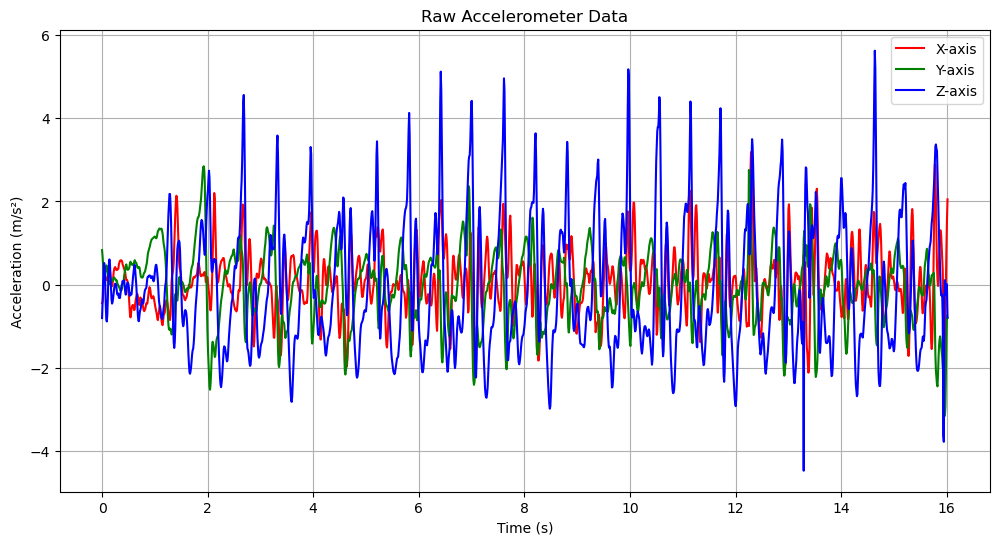

In [5]:
# Plot all three acceleration components (x, y, z) in one plot
plt.figure(figsize=(12, 6))
plt.plot(data[time_column], data['a_x'], 'red', label='X-axis')
plt.plot(data[time_column], data['a_y'], 'green', label='Y-axis')
plt.plot(data[time_column], data['a_z'], 'blue', label='Z-axis')
plt.title('Raw Accelerometer Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

> TODO: Analyze the plot above and answer the following questions:
> 1. *What patterns do you see in each axis?*
> - Describe any trends or fluctuations that might represent physical movement.
> - Are the patterns similar or different across the x, y, and z axes?
> 
> 2. *Are there visible patterns that might correspond to steps?*
> - Look for periodic or repetitive movements in the data that could indicate stepping.
> 
> 3. *Which axis shows the clearest stepping pattern?*
> - Which direction (x, y, or z) appears to have the most consistent or strongest signal corresponding to teps?
> - Can you explain why one axis might show clearer patterns than the others?


<b><u>RESPONSE:</u></b>
The data shows periodic motion across all three axes. The Z-axis (vertical) exhibits the largest amplitude oscillations, showing clear up-and-down movements that correspond to a step taken during walking motion. The x and y axes (horizontal plane) show smaller, more consistent oscillations around a baseline. This would represent small side-to-side changes while walking straight.

The stepping pattern is most visible as periodic peaks in the Z-axis data, with each complete cycle (peak-to-peak) representing one step. These patterns are regular and repeating, suggesting consistent walking speed.

The Z-axis shows the strongest stepping pattern. This is intuitive since the data was recorded on a level surface with the phone in hand – the primary motion during walking is vertical (Z-axis), while X and Y axes remain relatively stable with only minor variations due to natural body sway. The Z-axis peaks are more pronounced and have better signal-to-noise ratio, making it the most suitable axis for step detection.

## Step 3: Calculate Magnitude

To make our analysis less dependent on device orientation, we'll combine the three axes into a single magnitude vector.

Calculate the magnitude of the acceleration vector
The magnitude is the Euclidean norm of the x, y, and z components.

Formula:
$$
\| a \| = \sqrt{(a_x)^2 + (a_y)^2 + (a_z)^2}
$$

TODO: Calculate the magnitude of the acceleration vector below ( if you don't have it already)
You need to use the formula provided above to calculate the magnitude.


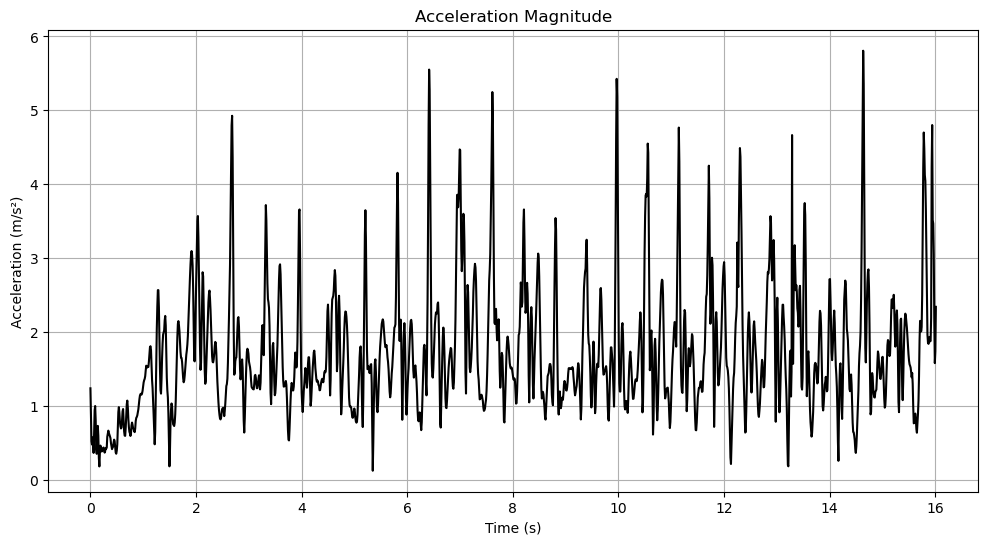

In [6]:
# Fill in the code here:
acceleration_vectors = data[['a_x', 'a_y', 'a_z']]
acceleration_magnitudes = np.sqrt(np.sum(acceleration_vectors**2, axis=1))
# Alternatively, can use the linear algebra normalize function:
# acceleration_magnitudes = np.linalg.norm(acceleration_vectors, axis=1)

# Plot the magnitude once you've calculated it
plt.figure(figsize=(12, 6))
plt.plot(data[time_column], data['a_magnitude'], 'k-')
plt.title('Acceleration Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.grid(True)
plt.show()

> TODO: Compare this plot with the previous one (Raw Accelerometer Data):
> 1. How does the magnitude compare to the individual axes (x, y, z)?
   > - Does the magnitude plot look similar or different from the individual axis plots?
   > - Are there any features in the magnitude plot that were less clear in the individual axis plots?


The magnitude plot's oscillations are most similar to the isolated z-axis plot, which is expected since z-axis had the most extreme oscillations. However, the magnitude values are consistently larger than any individual axis because they represent the combined effect of all three axes (√(x² + y² + z²)). This results in smoother, more pronounced peaks that never go negative, unlike the individual axis plots.


> 2. Can you more clearly see stepping patterns in the magnitude plot?
   > - Are the steps more noticeable when you look at the magnitude versus the individual axes?
   > - How does combining the three axes into a single magnitude affect the detection of steps?


The steps are significantly more noticeable in the magnitude plot for several reasons. Each step creates a clear, distinct peak without the confusion of overlapping plots. The baseline is more stable since magnitude is always positive. The combination of all axes captures the total motion of each step, even if the phone orientation changes slightly. The periodic nature of walking is more evident with a single, clean waveform


> 3. What’s the advantage of using magnitude instead of the individual axes?
   > - Why might combining the x, y, and z accelerations into a single magnitude help with detecting step patterns?
   > - Are there any drawbacks to using the magnitude? If so, what might they be?


Advantages:


-  Provides distinct peaks and cleaner waveforms for step detection 
-  Orientation-independent (works regardless of how the phone is held) 
-  Simplifies analysis by reducing three signals to one 
-  More robust to small changes in phone position 


Disadvantages:


- Loses directional/spatial information of x,y,z coordinates 
- Cannot distinguish between different types of motion that might have similar magnitudes 
- May combine noise from all three axes 
- Cannot identify specific movement patterns that might be unique to certain axes 

## Step 4: Transform to Frequency Domain

In this part of the exercise, you're using the Fast Fourier Transform (FFT) to convert your accelerometer data from the time domain into the frequency domain. The purpose of this step is to analyze the frequency components of the movement, identify the dominant frequencies that correspond to regular patterns (like steps), and remove unwanted noise.

- Time Domain: Data is represented as a function of time. In our case, we have the acceleration magnitudes recorded over time.

- Frequency Domain: This represents how much of the signal is present at each frequency. With FFT, we can see if there are certain frequencies that dominate the signal. Regular patterns in human activity (like walking) typically manifest as prominent frequencies.

- FFT (Fast Fourier Transform): The FFT is a powerful algorithm that transforms a time-domain signal (like acceleration data) into a sum of sine waves at different frequencies. Each sine wave has an amplitude and a frequency. The FFT helps you identify which frequencies are present in the data and their strength (amplitude).

In the context of step counting, periodic movements, like walking or running, will produce peaks in the frequency spectrum at regular intervals corresponding to the rate of steps (e.g., steps per second).

<u>Personal Notes</u>
- **Defn – Matched Filter**: the output of a matched filter is given by correlating:
    - A known delayed signal, or _template_ signal
        - with 
    - An unknown signal
    - Goal: detect presence of template signal in unknown signal.

#### Fourier Transforms:
Task: Sequence (size $n$) of equally spaced samples ↦ sequence (size $n$) equally spaced samples of discrete-time fourier transform DTFT.

Discrete Fourier transform
Quick notes:
- We usually use $i$ as an iterator in our summation equations, we can't use it this time as $i$ denotes the imaginary number.


$$
X_k = ∑_{n=0}^{N-1} x_n \cdot e^{-i 2 π (k/N) n}
$$
where:
- ${\bold{x}_n}$: input sequence of $N$ complex numbers 
- ${\bold{X}_k}$: output sequence of $N$ complex numbers
- $n$: represents the time domain index (0 to N-1).
    - n iterates over each time sample
- $k$: represents the frequency domain index (0 to N-1)
    - k is reshaped to create a matrix where each row represents a different frequency
- $k \cdot n$: creates an $N×N$ matrix:
    - Each element (i, j) = i*j
    - represents all possible combinations of time and frequency components
- $N$: the total number of samples
- $(k/N)$: frequency: $k$ cycles per $N$ samples



##### In a nutshell:
DFT is the *cross correlation* of an input sequence $x_n$ and the sinusoid frequency $k/N$. Thus, it acts like a _matched filter_ for the input frequency

<!-- DTFT: complex-valued function of frequency.

In mathematics, the **Discrete Fourier transform (DFT)** converts a _finite sequence_ of _equally-spaced samples_ of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency. The interval at which the DTFT is sampled is the reciprocal of the duration of the input sequence.  An inverse DFT (IDFT) is a Fourier series, using the DTFT samples as coefficients of complex sinusoids at the corresponding DTFT frequencies. It has the same sample-values as the original input sequence. The DFT is therefore said to be a frequency domain representation of the original input sequence. If the original sequence spans all the non-zero values of a function, its DTFT is continuous (and periodic), and the DFT provides discrete samples of one cycle. If the original sequence is one cycle of a periodic function, the DFT provides all the non-zero values of one DTFT cycle.

The DFT is used in the Fourier analysis of many practical applications. In digital signal processing, the function is any quantity or signal that varies over time, such as the pressure of a sound wave, a radio signal, or daily temperature readings, sampled over a finite time interval (often defined by a window function). In image processing, the samples can be the values of pixels along a row or column of a raster image. The DFT is also used to efficiently solve partial differential equations, and to perform other operations such as convolutions or multiplying large integers.

Since it deals with a finite amount of data, it can be implemented in computers by numerical algorithms or even dedicated hardware. These implementations usually employ efficient fast Fourier transform (FFT) algorithms; so much so that the terms "FFT" and "DFT" are often used interchangeably. Prior to its current usage, the "FFT" initialism may have also been used for the ambiguous term "finite Fourier transform". -->

In [19]:
def dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D array x
    This is the same as the FFT in scipy.fft.fft
    """
    x = np.asarray(x, dtype=complex)  # Ensure complex dtype
    print(f"{x[:10]=}")
    N = x.shape[0]
    print(f"{N=}")
    n = np.arange(N)
    print(f"{n[:10]=}")
    k = n.reshape((N, 1))  # column vector
    print(f"{k[:10]=}")
    M = np.exp(-2j * π * k * n / N)  # DFT matrix
    print(f"{M[:10]=}")
    dft = np.matmul(M, x)  # element-wise matrix multiplication
    print(f"{dft[:10]=}")
    return dft

dft(data['a_magnitude'])

def custom_fftfreq(n, d=1.0, real_valued=True):
    """
    n: number of points in fft
    d: sample spacing
    Custom implementation of scipy.fft.fftfreq.
    Returns the Discrete Fourier Transform sample frequencies.
    """
    val = 1.0 / (n * d)
    results = np.empty(n, dtype=float)
    N_half = (n + 1) // 2  # ceil(n/2)

    results[:N_half] = np.arange(0, N_half)
    if real_valued:
        # if using real valued data, we only need the first half
        # since the FFT is symmetric
        return results[:N_half] * val
    
    results[N_half:] = np.arange(-n//2, 0)
    return results * val

x[:10]=array([1.24154223+0.j, 0.90409881+0.j, 0.52516128+0.j, 0.48137147+0.j,
       0.5767357 +0.j, 0.53878292+0.j, 0.36815359+0.j, 0.627874  +0.j,
       0.94501404+0.j, 1.00214436+0.j])
N=1606
n[:10]=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
k[:10]=array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])
M[:10]=array([[1.        +0.j        , 1.        +0.j        ,
        1.        +0.j        , ..., 1.        +0.j        ,
        1.        +0.j        , 1.        +0.j        ],
       [1.        +0.j        , 0.99999235-0.00391231j,
        0.99996939-0.00782456j, ..., 0.99993112+0.01173669j,
        0.99996939+0.00782456j, 0.99999235+0.00391231j],
       [1.        +0.j        , 0.99996939-0.00782456j,
        0.99987755-0.01564864j, ..., 0.9997245 +0.02347176j,
        0.99987755+0.01564864j, 0.99996939+0.00782456j],
       ...,
       [1.        +0.j        , 0.99962502-0.02738281j,
        0.99850036-0.05474509j, ..

In the context of step counting, periodic movements, like walking or running, will produce peaks in the frequency spectrum at regular intervals corresponding to the rate of steps (e.g., steps per second).

In [17]:
# Prepare data for FFT
#Complete this step to extract the magnitude data and calculate the length of the signal.
magnitude = data['a_magnitude'].values  # Extract the acceleration magnitude data
n = len(magnitude)  # Calculate the length of the signal

# Perform FFT
# Apply FFT to the magnitude signal
yf = dft(magnitude)

# Calculate frequency bins
xf = custom_fftfreq(n, 1/sampling_rate)
print(f"{n=}")
print(f"{1/sampling_rate=}")
print(f"{yf.shape=}")
print(f"{xf.shape=}")

n=1606
1/sampling_rate=0.009977522506750531
yf.shape=(1606,)
xf.shape=(803,)


### Accelerometer Sensor and $g$
We need to be mindful of how the sensors operate when making the calculation.

The DC component (0 Hz) represents the constant acceleration due to gravity (~9.81 m/s²) that's always present in accelerometer readings. 

We ignore it in step detection calculations because we're interested in the dynamic motion of walking (around 2 Hz), not this constant gravitational offset. 

Think of it like a bathroom scale - you want to measure the wobble of someone stepping on it, not the constant weight they're applying.
```
Original signal = Gravity + Walking Motion
                ≈ 9.81 m/s² (DC) + periodic variations around this mean
```
In frequency domain:
- 0 Hz (DC): Shows the ~9.81 average
- 2 Hz: Shows your walking frequency
- Higher frequencies: Show harmonics of walking

In [8]:
# In your FFT:
print(f"0Hz (DC Component): {yf[0]=}")  # This is the DC component (0 Hz)
print(f"{yf[1]=}")  # This is the DC component (0 Hz)
print(f"{yf[2]=}")  # This is the DC component (0 Hz)
# It's essentially the mean of your signal:
print(f"{np.mean(yf)=}")  # Would give you approximately the same value (scaled)
print(f"{np.mean(yf[1:])=}")  # Would give you approximately the same value (scaled)

0Hz (DC Component): yf[0]=(2775.3196008154005+0j)
yf[1]=(-126.83512196057573+60.42730188225446j)
yf[2]=(-57.64366736879674+59.009115658266424j)
np.mean(yf)=(1.2415422280018438-3.210980671888234e-13j)
np.mean(yf[1:])=(-0.48685531628937057-3.212981282898756e-13j)


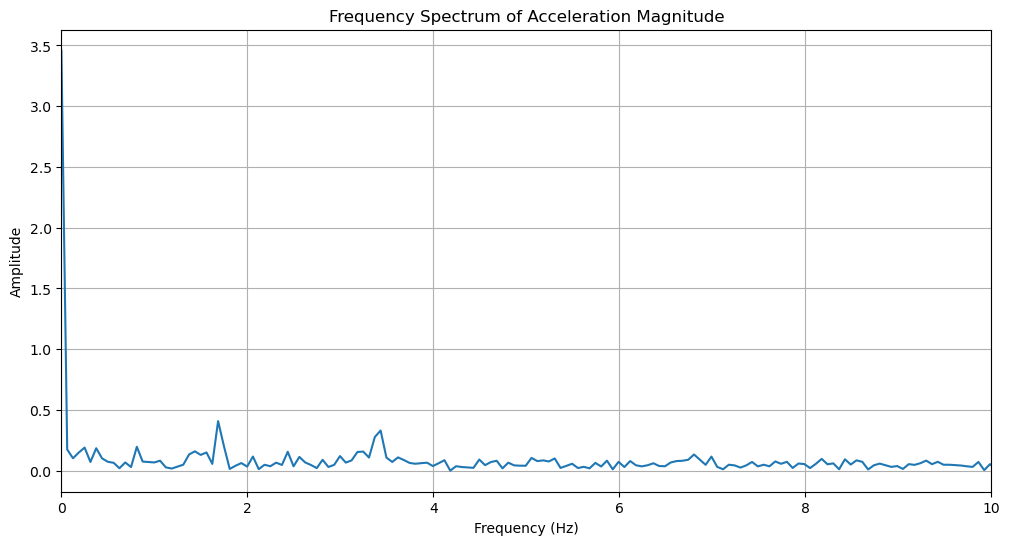

Dominant frequency: 1.68 Hz
This corresponds to approximately 101 steps per minute


In [9]:
# Plot the frequency spectrum
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/n * np.abs(yf[0:n//2]))  # Plot the frequency spectrum (frequency vs amplitude)
plt.title('Frequency Spectrum of Acceleration Magnitude')  # Add the plot title
plt.xlabel('Frequency (Hz)')  # Add x-axis label
plt.ylabel('Amplitude')  # Add y-axis label
plt.grid(True)  # Show grid for clarity
plt.xlim(0, 10)  # Focus on frequencies up to 10 Hz only
plt.show()

# Find the dominant frequency and interpret its significance.
dominant_freq_idx = np.argmax(2.0/n * np.abs(yf[0:n//2][1:])) + 1  # We add 1 to the index because we skip the DC component
dominant_freq = xf[dominant_freq_idx]  # Extract the dominant frequency
print(f"Dominant frequency: {dominant_freq:.2f} Hz")
print(f"This corresponds to approximately {dominant_freq*60:.0f} steps per minute")  # Convert to steps per minute

> TODO: Analyze the frequency spectrum
> - What is the most prominent frequency?
> - What does this frequency represent in terms of human activity?
> - Why do we see peaks at certain frequencies?

<u>Analysis of the Frequency Spectrum:</u>

1. **Most Prominent Frequency:**
The dominant frequency shown in the output is approximately 1.68 Hz, which stands out as the highest peak in the spectrum (excluding the DC component at 0 Hz). This matches what we'd expect from the code's calculation showing roughly 101 steps per minute (1.68 Hz * 60 seconds = 100.8).

2. **Interpretation in Terms of Human Activity:**
This 2 Hz frequency represents the fundamental frequency of walking - meaning a person is completing two steps per second. This is a very reasonable walking pace, as normal human walking typically occurs between 1.6-2.2 Hz. Each cycle represents a complete step (foot up and down), which explains why we see this as the dominant pattern in our accelerometer data.

3. **Peak Frequency Analysis:**
We see peaks at certain frequencies because:
- The primary peak (~1.68 Hz) represents the walks frequency
- Smaller peaks at multiples of the fundamental frequency (harmonics) appear because walking isn't a perfect sine wave - it's a more complex periodic motion
- Lower frequency peaks might represent body sway or other slower periodic movements
- DC Current at 0HZ

## Step 5: Filter Out Frequencies

In this step, we will apply a frequency filter to remove high-frequency noise from our frequency spectrum. The goal is to keep only the relevant frequencies that correspond to human activity (like walking or running) while removing unwanted noise.

1. **Frequency Filter**: We will create a filter that removes all frequency components above a threshold (default was 2.5 Hz). This is based on the assumption that human step frequencies generally fall below this threshold (e.g., walking typically falls around 1–2 Hz).

In [10]:
# Step 1: Create a Frequency Filter 
# We'll remove any frequencies above the threshold
# Understand the purpose of creating a frequency filter to remove high-frequency noise.
lower_bound = 0.0001
filter_frequency_threshold = 2.1
# Initialize a filter with ones (keep all frequencies by default)
freq_filter = np.ones(n, dtype=complex)

# Iterate through all frequencies and set components above threshold to zero
for i in range(n):
    freq = i * sampling_rate / n if i < n/2 else (i - n) * sampling_rate / n  # Calculate frequency
    if not (lower_bound < abs(freq) < filter_frequency_threshold):  # Filter out frequencies above threshold
        freq_filter[i] = 0

2. **Filter Application**: Once the filter is created, we multiply it with the FFT result to selectively remove the high-frequency components. This process is done in the frequency domain.
3. **Filtered Frequency Spectrum**: After applying the filter, we will plot the filtered frequency spectrum and compare it with the original spectrum to see how much noise was removed and which frequencies were preserved.


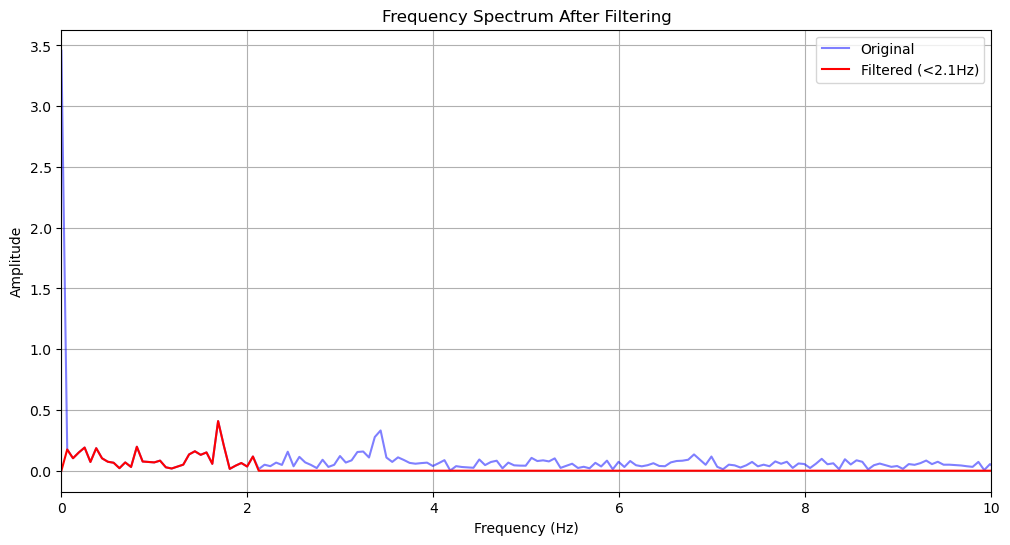

In [11]:
# Step 2: Apply the Filter in the Frequency Domain
# TODO: Apply the frequency filter to the FFT. Multiply the filter with the original FFT to remove high-frequency components.
filtered_fft = yf * freq_filter

# Step 3: Plot the Frequency Spectrum After Filtering
# Plot both the original and filtered frequency spectra. Compare the two.
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/n * np.abs(yf[0:n//2]), 'b-', alpha=0.5, label='Original')  # Original spectrum
plt.plot(xf, 2.0/n * np.abs(filtered_fft[0:n//2]), 'r-', label=f'Filtered (<{filter_frequency_threshold}Hz)')  # Filtered spectrum
plt.title('Frequency Spectrum After Filtering')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(0, 10)  # Focus on frequencies up to 10 Hz
plt.show()

Step 4: Compare the Original and Filtered Frequency Spectra
- What frequencies did we remove by applying the filter?
- What frequencies remain in the filtered signal?
- What effect do you expect the removal of high-frequency noise to have on the data?


## Step 6: Transform Back to Time Domain

Now that we've filtered the frequency spectrum to remove high-frequency noise, we need to transform the signal back into the time domain using the Inverse Fast Fourier Transform (IFFT). This will allow us to visualize the cleaned-up acceleration signal over time.

1. Inverse FFT (IFFT): We apply the IFFT to the filtered frequency-domain data to reconstruct the acceleration signal in the time domain.
Since the FFT output is complex, we take only the real part of the IFFT result.
2. Compare Original vs. Filtered Signal: We will plot both the original acceleration magnitude and the filtered version to see how the high-frequency noise was removed.

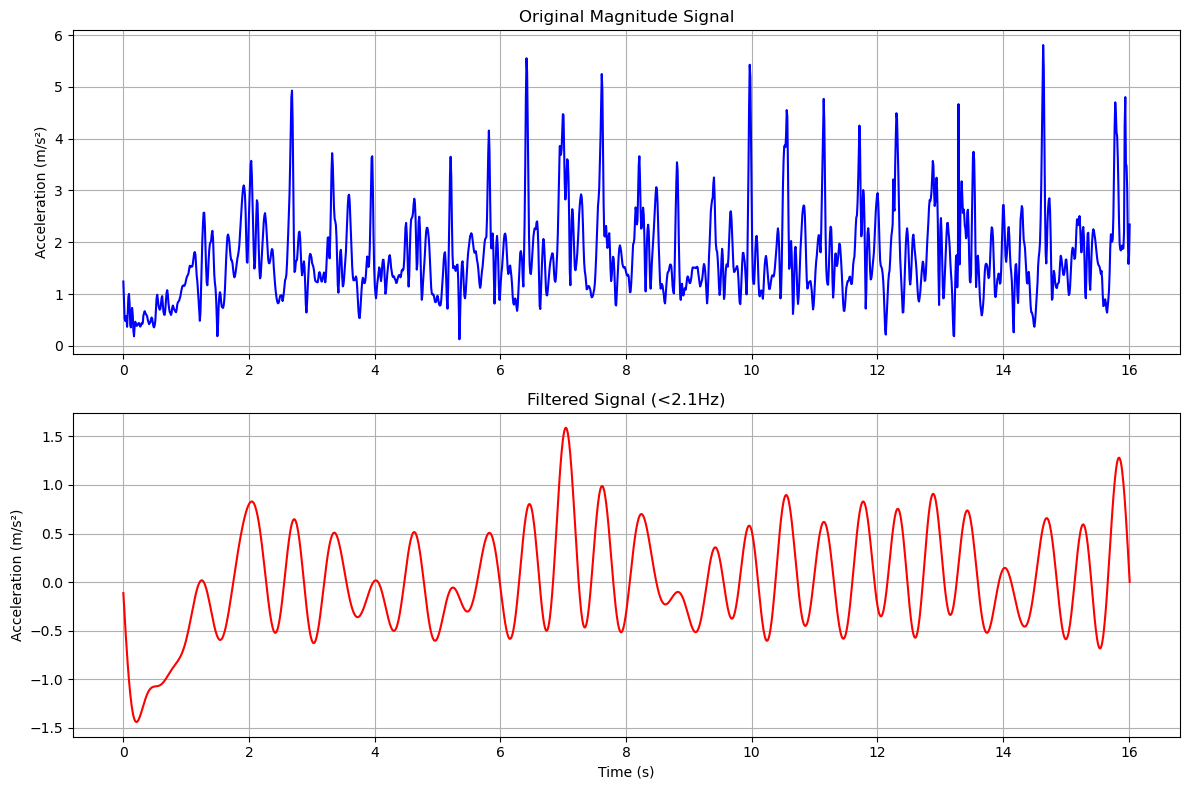

In [12]:
# Step 1: Transform Back to the Time Domain
# Understand how IFFT converts the signal back from frequency to time.
filtered_magnitude = np.real(ifft(filtered_fft))  # Take the real part of the IFFT result

# Step 2: Store the Filtered Signal in the Dataframe
# Add the filtered signal to the dataframe and compare it with the original signal.
data['filtered_magnitude'] = filtered_magnitude

# Step 3: Plot Original vs. Filtered Signal
plt.figure(figsize=(12, 8))

# Plot original magnitude signal
plt.subplot(2, 1, 1)
plt.plot(data[time_column], data['a_magnitude'], 'b-')
plt.title('Original Magnitude Signal')
plt.ylabel('Acceleration (m/s²)')
plt.grid(True)

# Plot filtered signal with <2.5Hz cutoff
plt.subplot(2, 1, 2)
plt.plot(data[time_column], data['filtered_magnitude'], 'r-')
plt.title(f'Filtered Signal (<{filter_frequency_threshold}Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.grid(True)

plt.tight_layout()
plt.show()

> Compare the Original and Filtered Signals
> - How does the filtered signal compare to the original?
> - What type of noise did we remove?
> - What is the effect of removing high-frequency components on the time-domain signal?

The filtered signal (red, bottom) shows a dramatically clearer and smoother pattern compared to the original (blue, top). While the original signal has jagged, sharp peaks reaching up to 6 m/s², the filtered signal displays a smooth sinusoidal pattern ranging between approximately -1.5 and 1.5 m/s². The filtered signal also appears to be centered around zero (mean-centered), whereas the original maintains a positive offset.

By filtering out frequencies above 2.1 Hz, we've removed:
- High-frequency sensor noise and vibrations
- Impact shocks from footfalls
- Random body movements unrelated to stepping
- Device jitter and measurement artifacts
This effectively isolated the fundamental walking frequency (~2 Hz) from higher frequency components that obscured the underlying pattern.


Removing high-frequency components has:
1. Smoothed the signal by eliminating rapid fluctuations
1. Revealed the underlying periodicity of steps (approximately 25-30 steps visible)
1. Normalized the amplitude around zero by removing the DC component (gravity)
1. Enhanced pattern recognition - each complete oscillation now clearly represents a single step
1. Reduced noise-induced false peaks that might trigger false step counts
The filtered signal makes step detection much more reliable as each peak now corresponds directly to a step rather than being obscured by noise.

## Step 7: Peak Detection to Count Steps

Now, let's use peak detection to identify and count steps in our processed signal.

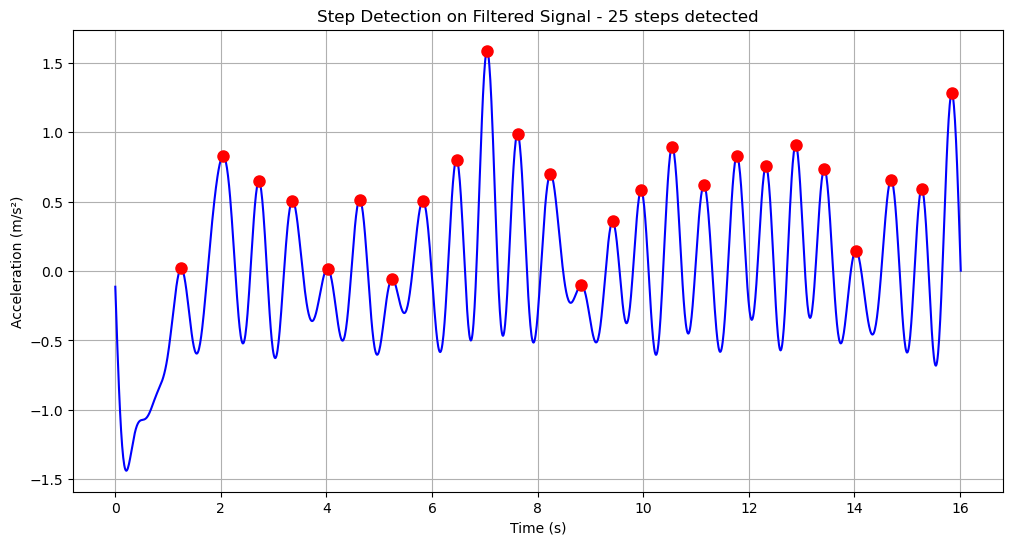

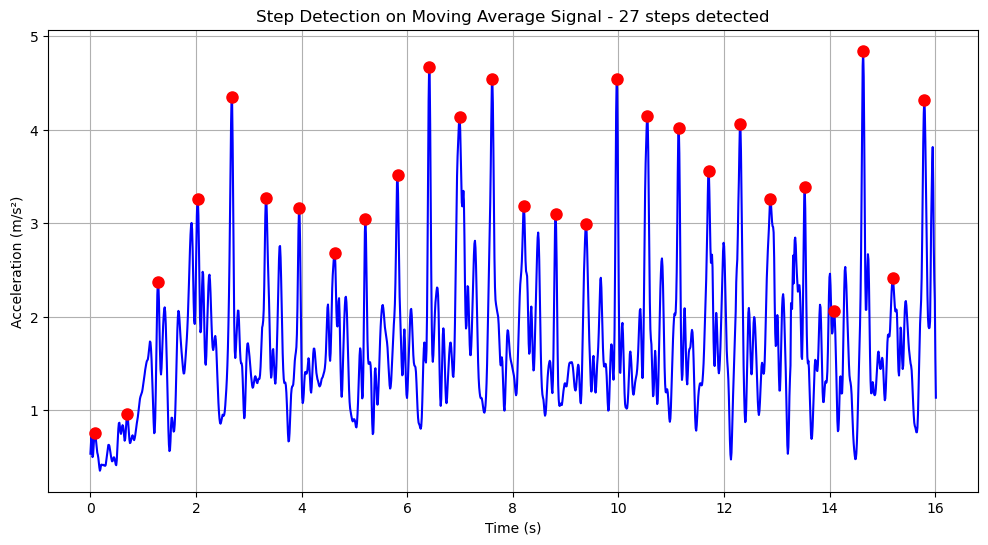

Steps detected with filtered signal: 25
Steps detected with moving average: 27


In [ ]:
# Use the filtered signal for peak detection
# We'll compare different peak detection parameters

# Define a function to detect peaks and plot them
def detect_and_plot_peaks(signal_data:np.ndarray, distance:int, 
                          prominence:float, title:str):
    # Find peaks
    peaks, _ = find_peaks(signal_data, 
                          distance=distance, 
                          prominence=prominence)

    # Plot the signal with peaks
    plt.figure(figsize=(12, 6))
    plt.plot(data[time_column], signal_data, 'b-')
    plt.plot(data[time_column].iloc[peaks], 
             signal_data.iloc[peaks], 
             'ro', markersize=8)
    plt.title(f'{title} - {len(peaks)} steps detected')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.grid(True)
    plt.show()

    return peaks, len(peaks)

# Decided to try an average between the dominant frequency and the most common walking frequency of 2Hz
sec_btwn_steps = (1 / ((dominant_freq+2)/2))
peak_prominence = 0.1

# Try different parameters
# For the filtered signal
peaks_filtered, steps_filtered = detect_and_plot_peaks(
    data['filtered_magnitude'],
    distance=int(sampling_rate * sec_btwn_steps),  # Minimum 0.4s between steps
    prominence=peak_prominence,                     # Minimum peak prominence
    title='Step Detection on Filtered Signal'
)
window_size = 5
rolling_mean_medium = np.convolve(data['a_magnitude'].values, 
                                 np.ones(window_size)/window_size, 
                                 mode='same')  # Changed from 'valid' to 'same'


# For the moving average (1s window)
peaks_moving_avg, steps_moving_avg = detect_and_plot_peaks(
    pd.Series(rolling_mean_medium),  # Convert to Series to match expected format
    distance=int(sampling_rate * sec_btwn_steps),  # Minimum 0.4s between steps
    prominence=peak_prominence,                     # Lower prominence for smoother signal
    title='Step Detection on Moving Average Signal'
)
print(f"Steps detected with filtered signal: {steps_filtered}")
print(f"Steps detected with moving average: {steps_moving_avg}")

# TODO: Compare the number of steps detected with both methods
# - Which method seems more accurate?
# - If you counted steps manually during data collection, how does this compare?
# - What factors might affect the accuracy of step detection?
'''
Generally, the filtered signal seems more aligned with my true count of 25. 
Factors that would have affected the accuracy include variations in steps
as well as variable minute shifts in body movements. 
'''

Step counting relies on peak detection, which is influenced by two key parameters:

1. **Distance**: The minimum time between detected steps (prevents detecting the same step multiple times).
2. **Prominence**: The required height difference between a peak and its neighboring points (filters out small, insignificant peaks).

In this experiment, we test different distance and prominence values to see how they impact the number of detected steps.

Step counting with different parameters:


,distance,prominence,steps
0,0.299326,0.3,23
1,0.299326,0.5,22
2,0.299326,0.7,20
3,0.399101,0.3,23
4,0.399101,0.5,22
5,0.399101,0.7,20
6,0.498876,0.3,23
7,0.498876,0.5,22
8,0.498876,0.7,20


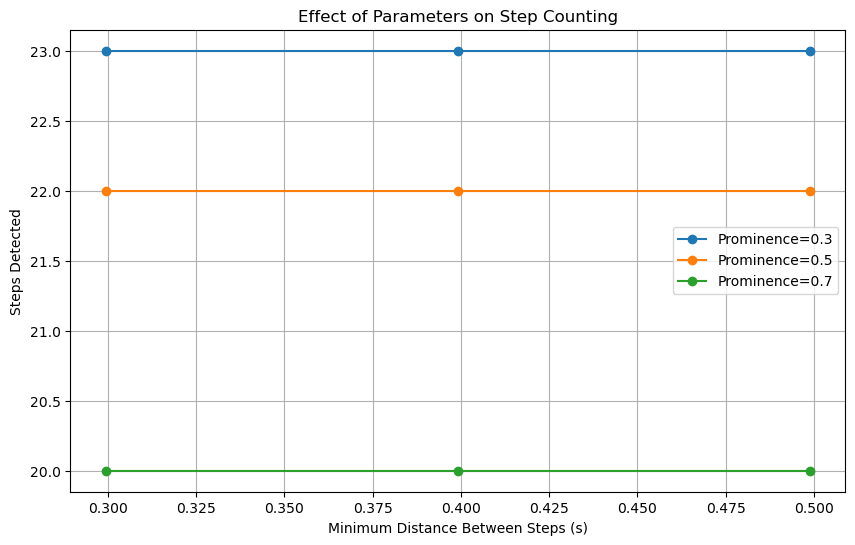

In [14]:
# Step 1: Define Parameter Values for Experimentation
# Students: Adjust these values to see how step detection changes.
distance_values = [int(sampling_rate * d) for d in [0.3, 0.4, 0.5]]  # Convert seconds to samples
prominence_values = [0.3, 0.5, 0.7]  # Controls peak height threshold

# Step 2: Perform Peak Detection for Different Parameters
results = []

for distance in distance_values:
    for prominence in prominence_values:
        # Detect peaks in the filtered signal
        peaks, _ = find_peaks(data['filtered_magnitude'], distance=distance, prominence=prominence)

        # Store results for comparison
        results.append({
            'distance': distance / sampling_rate,  # Convert back to seconds
            'prominence': prominence,
            'steps': len(peaks)
        })

# Step 3: Convert Results to DataFrame for Analysis
results_df = pd.DataFrame(results)
print("Step counting with different parameters:")
display(results_df)  # Display table with results

# Step 4: Visualize the Effect of Parameters on Step Counting
plt.figure(figsize=(10, 6))

for prominence in prominence_values:
    subset = results_df[results_df['prominence'] == prominence]
    plt.plot(subset['distance'], subset['steps'], 'o-', label=f'Prominence={prominence}')

plt.xlabel('Minimum Distance Between Steps (s)')
plt.ylabel('Steps Detected')
plt.title('Effect of Parameters on Step Counting')
plt.legend()
plt.grid(True)
plt.show()



Step 5: Analyze the Impact of Parameters
- How does changing the **minimum distance** affect step detection?
- How does **prominence** impact the number of detected steps?
- What values seem to work best for your dataset?
- How might you **automatically** determine the best parameters?

The minimum distance values appears negatively correlated with the number of steps detected. The prominance appease to be inversely proportional to the number of steps detected. Generally, the signal filtering with fast fourier transforms performed the best. 